# 💮Flower-Classifier ![Static Badge](https://img.shields.io/badge/Udacity-%232B00FF?style=for-the-badge&logo=Udacity&logoColor=white)
![Static Badge](https://img.shields.io/badge/Python-blue?logo=Python&logoColor=white)
![Static Badge](https://img.shields.io/badge/Jupyter_Notebook-orange?logo=Jupyter&logoColor=white)
![Static Badge](https://img.shields.io/badge/TensorFlow-orange?logo=TensorFlow&logoColor=white)
![Static Badge](https://img.shields.io/badge/status-completed-green)

A convolutional neural network to classify 5 different types of flowers. Avoidance of overfitting through data augmentation and dropout.

## 🏁The goal

Classifying images can be a tough task, even more if there are lots of images to classify. It is obvious that at the beggining we will have to do it manually. Eventhough, since it is a repetitive task, we could train a neural network to do the job for us, using all the data that we classified manually.

In these types of tasks, the usual thing is to analyze all the patterns and design an algorithm. To analyze images, figuring out all the hidden patterns would be such a painfull work; instead of that, a neural network can handle the job. The type of neural network that we will use will be a [convolutional](https://en.wikipedia.org/wiki/Convolutional_neural_network) one. The reason why is that it is equipped with tools that make the analysis of spacial patterns in images, such as contrast lines, hue gradients and so on.

The goal of the model will be to take an image of a flower and output a probability distribution corresponding to each type of flower it "thinks" it is.

In [ ]:
import os # system management
import numpy as np # arrays
import glob # filenames
import shutil # moving files
import matplotlib.pyplot as plt # plotting
import tensorflow as tf # neural networks
from tensorflow.keras.models import Sequential # sequential arquitecture
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D # different layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator # data generator from dataset

## 📑Dataset

The dataset will be taken from the official [TensorFlow examples](https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz). Using ``tf.keras.utils.get_file`` and extracting the ``.tgz`` file, we end up with a folder with all the already classified images.


In [ ]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos_extracted/flower_photos')

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Using the ``os`` module, we assign to ``base_dir`` the following path: ``/root/.keras/datasets/flower_photos_extracted/flower_photos``. In future versions of the ``tf.keras`` module this could change; so, please, check where is your ``flower_photos`` directory.

```output
/
└── root/
    └── .keras/
        └── datasets/
            └── flower_photos_extracted/
                └── flower_photos/
                    ├── daisy
                    ├── dandelion
                    ├── roses
                    ├── sunflowers
                    └── tulips
```
As it can be seen, we have 5 types of flowers: roses, daisy, dandelion, sunflowers and tulips.

In [ ]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

### 📁Getting the data ready

Now, using these ``classes``, we have to create directories to separate the **training** data from the **validation** data. To do so, we use the ``os``, ``blob`` and ``shutil`` modules; they allow us to move, create and select files/directories.

In [ ]:
for cl in classes:
  # search for the class directory
  img_path = os.path.join(base_dir, cl)
  # pick up the list of all .jpg images inside the dir
  images = glob.glob(img_path + '/*.jpg')
  # show how many are there
  print("{}: {} Images".format(cl, len(images)))
  # choose an 80% of the images to train
  num_train = int(round(len(images)*0.8))
  # classify them
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      # create "train/class" folder
      os.makedirs(os.path.join(base_dir, 'train', cl))
    # move all the images there
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  # repeat for validation
  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

# set up the paths
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


Now, our training and validation datasets are contained in the paths pointed by ``train_dir`` and ``val_dir``.

```output
/
└── root/
    └── .keras/
        └── datasets/
            └── flower_photos_extracted/
                └── flower_photos/
                    ├── daisy
                    ├── dandelion
                    ├── roses
                    ├── sunflowers
                    ├── tulips
                    ├── train/
                    │   ├── daisy
                    │   ├── dandelion
                    │   ├── roses
                    │   ├── sunflowers
                    │   └── tulips
                    └── val/
                        ├── daisy
                        ├── dandelion
                        ├── roses
                        ├── sunflowers
                        └── tulips
```

## 1️⃣First model (overfitted)

To see an example of a simple model, we will train a neural network and will observe how it overfits. This is really common when beggining to work with neural networks. It is a phenomonon that is hard to avoid if you do not know where does it come from and how the network is designed internally.

The first thing to do is setting up an ``image data generator``. This is a ``tensorflow.keras`` object that takes a directory (not loaded in the stack), processes images and makes batches out of it. This is a really useful tool to avoid your RAM overloading. Also, it has built-in tools that preprocess the image randomly, so the model can work out with an alternative version of the image to avoid overfitting (we will see this later).

The colors of the image (given by a ``[R,G,B]`` vector) will be normalized to 1 (that means, dividing them by 255). Finally, since simple neural networks can only work with a fixed image resolution, we will have to rescale them every time we try to feed them into the model (150x150 px).

The data generator will be set up to read from a directory (``train_dir``), using ``.flow_from_directory`` we can specify all the configurations (such as batch_size, order, target size, etc). A very important argument of this method is the ``class_mode='sparse'``. This allows the data batch to include the final outputs depending on the directories where these images come from. Somehow, the directories where these images are contained work as a label, and they are set into the ``train_data_gen`` variable.

In [ ]:
batch_size = 100
IMG_SHAPE = 150

image_gen = ImageDataGenerator(rescale=1./255)

train_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

Found 2935 images belonging to 5 classes.


Also, we can create an ``image data generator`` for the validation set:

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 735 images belonging to 5 classes.


### 🧠Creating the Neural Network

As we said, we will be using a convolutional one. Basically it consists of some layers that operate ([convolution](https://en.wikipedia.org/wiki/Convolution)) the image with some filters (the weight functions, mathematically) and output a new image. After each convolution we will apply a [MaxPooling layer](https://en.wikipedia.org/wiki/Pooling_layer), which chooses the highest value out of the dimensions we indicate it. In our case, each MaxPooling layer will have dimensions 2x2, which means that the resulting image will have half the size (1/4 of the area).

We will apply the same combination 3 times, using 16, 32 and 64 filters respectively. Also, we will use the relu [activation function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)), which allows us to capture the non-linear behaviour.

After that, We will flatten all the image components and apply dense layers until it reaches de desired size: 5 (for the 5 types of flowers).

In [ ]:
model1 = Sequential()

model1.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, 3, padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, 3, padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(512, activation='relu'))

model1.add(Dense(5))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


We can visualize how the model is built with the ``.summary()`` method.

In [ ]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,643,493 (40.60 MB)

 Trainable params: 10,643,493 (40.60 MB)

 Non-trainable params: 0 (0.00 B)

Now, we compile the model and set up how we want it to be trained. The optimizer will be the ``adam`` one (it is the most usual for simple neural networks. The loss function (which ``adam`` will try to minimize) will be the [sparse categorical cross entropy ](https://en.wikipedia.org/wiki/Cross-entropy). This one is basically a way to quantify how sure are we that we guessed the right type of flower.

In [ ]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 80

history = model1.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 438ms/step - accuracy: 0.2546 - loss: 2.0802 - val_accuracy: 0.3660 - val_loss: 1.4515
Epoch 2/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - accuracy: 0.4178 - loss: 1.3484 - val_accuracy: 0.4912 - val_loss: 1.1771
Epoch 3/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - accuracy: 0.5469 - loss: 1.0885 - val_accuracy: 0.5619 - val_loss: 1.0584
Epoch 4/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 0.6225 - loss: 0.9662 - val_accuracy: 0.6082 - val_loss: 0.9906
Epoch 5/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step - accuracy: 0.6560 - loss: 0.8601 - val_accuracy: 0.6408 - val_loss: 0.9382
Epoch 6/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - accuracy: 0.7261 - loss: 0.7217 - val_accuracy: 0.6354 - val_loss: 0.9788
Epoch 7/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.7758 - loss: 0.6074 - val_accuracy: 0.6095 - val_loss: 1.1206
Epoch 8/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step - accuracy: 0.8138 - loss: 0.5221 - val_accuracy:

After approximately 11 minutes, we have our model trained. We can plot the accuracies and loss functions of the different trainig/validation sets:

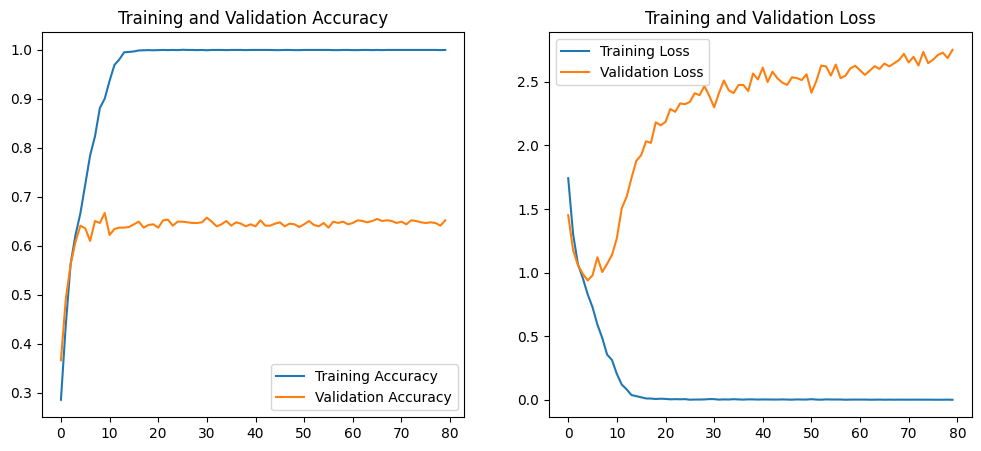

In [ ]:
# define the y values of the plots
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# define the x values
epochs_range = range(epochs)

# plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

# plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()

As it can be seen, both accuracies begin to grow with the same rate at the beggining. When reaching 4 epochs, both curves get separated (the same happens with the loss function). The validation accuracy gets stuck at ~65%, while the training one grows up to ~100%.

This phenomenon is called **overfitting**. Basically, our model has learned the training set so perfectly that fails at predicting data outside of it. We now have the task to improve the model using overfitting avoidance techniques.

<img src="https://hackernoon.imgix.net/hn-images/1*SBUK2QEfCP-zvJmKm14wGQ.png?w=1200" alt="Alt text" width="581" height="151"/>

## 2️⃣Second model

The problem of the first one was overfitting. There are [different techniques](https://hackernoon.com/memorizing-is-not-learning-6-tricks-to-prevent-overfitting-in-machine-learning-820b091dc42) to avoiod it, we will use **data augmentation** and **dropout**. We will explan them a little bit to get more context.

### ⏫Data augmentation

This tecnique consists basically on modifying a little bit the data that is used to train in each batch. This can be achieved easily using the ``image data generator``. This time, we will call the function ``ImageDataGenerator`` with more arguments.

As before, we still use the rescaling (1/255), and add more features:

* **Rotation range**: rotates randomly the image between 0 and the angle we want (45º).
* **Width/Height shift range**: stretches the image dimensions randomly within a percentage (15%).
* **Horizontal flip**: Randomly, flips the image horizzontally.
* **Zoom range**: Makes a zoom to the image within a certain percentage (50%).

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

Found 2935 images belonging to 5 classes.


We can now plot 5 different examples of how these transformations are applied randomly each time we call the ``train_data_gen`` variable (which is an ``ImageDataGenerator``).

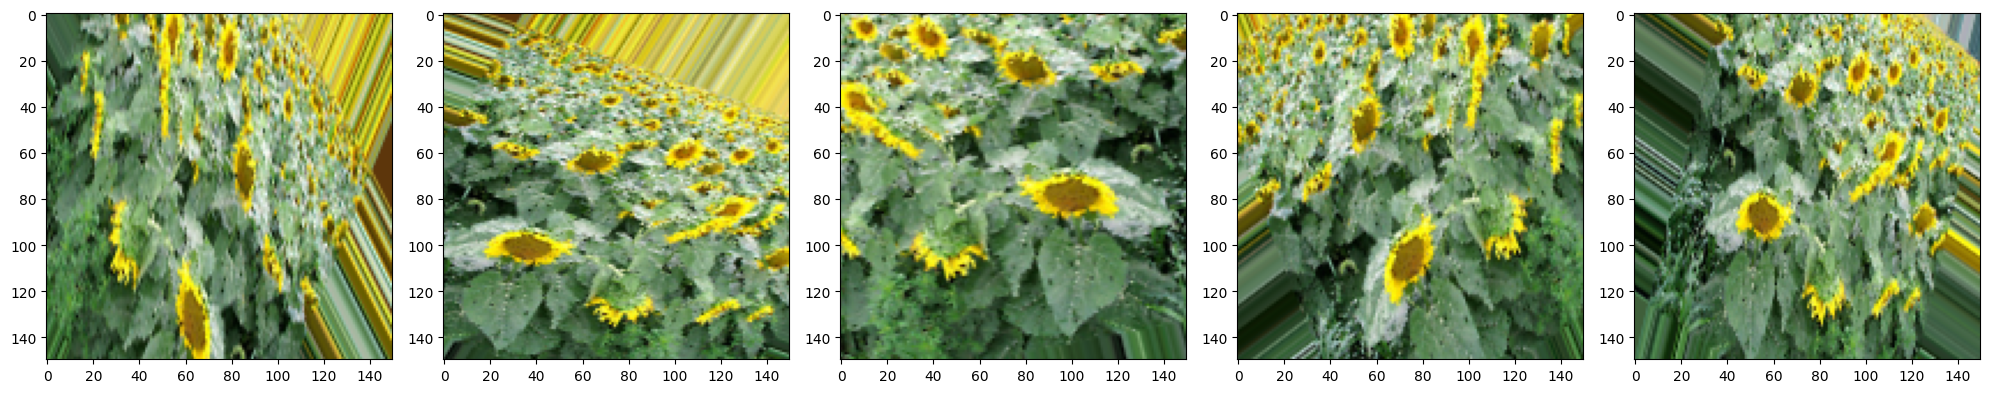

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

The validation set stays the same, since it is not used for training (it will not change the overfitting conditions).


### 💧Dropout

This other technique consists on deactivating some of the neurons during the training. This is something that we implement inside the model while deciding its architecture. For our case, we will put dropout layers right at the end, before each dense layer.


<img src="https://hackernoon.imgix.net/hn-images/1*DfrGMZdwpRQITkdmOtKwtg.jpeg?w=1200" alt="Alt text" width="581" height="301"/>

In [ ]:
model2 = Sequential()

model2.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, 3, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, 3, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(512, activation='relu'))

model2.add(Dropout(0.2))
model2.add(Dense(5))

model2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    10,617,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,643,493 (40.60 MB)

 Trainable params: 10,643,493 (40.60 MB)

 Non-trainable params: 0 (0.00 B)

### 🏃Training

After all this, we recompile and train the new model.

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 80

history = model2.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 815ms/step - accuracy: 0.2366 - loss: 2.2841 - val_accuracy: 0.4340 - val_loss: 1.2966
Epoch 2/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 36s 725ms/step - accuracy: 0.4536 - loss: 1.2647 - val_accuracy: 0.5156 - val_loss: 1.1398
Epoch 3/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 739ms/step - accuracy: 0.5371 - loss: 1.1284 - val_accuracy: 0.5524 - val_loss: 1.1122
Epoch 4/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 756ms/step - accuracy: 0.5883 - loss: 1.0531 - val_accuracy: 0.5891 - val_loss: 1.1193
Epoch 5/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.6096 - loss: 0.9751 - val_accuracy: 0.6354 - val_loss: 1.0205
Epoch 6/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step - accuracy: 0.6272 - loss: 0.9459 - val_accuracy: 0.6367 - val_loss: 0.9870
Epoch 7/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 738ms/step - accuracy: 0.6438 - loss: 0.9169 - val_accuracy: 0.6435 - val_loss: 0.9796
Epoch 8/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 685ms/step - accuracy: 0.6415 - loss: 0.8922 - val_accu

After 40 minutes, the model is completely trained. Again, we can plot the accuracies and loss functions:

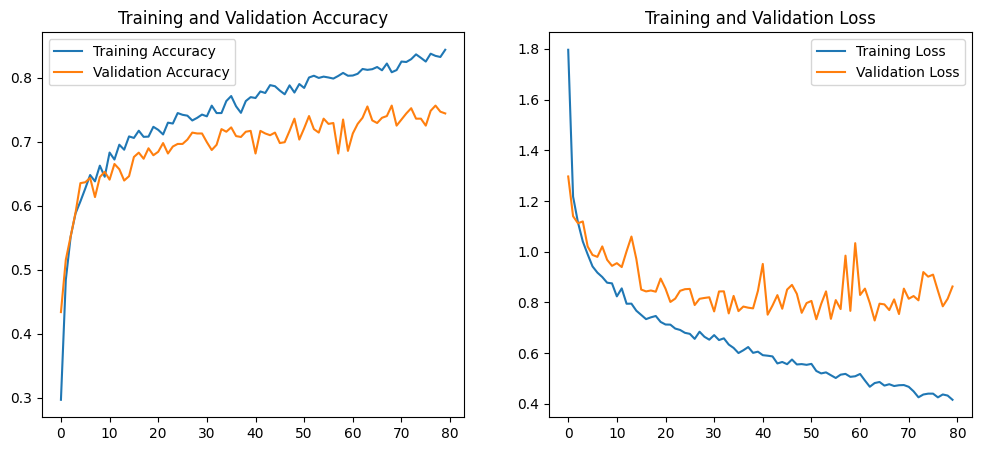

In [ ]:
# define the y values of the plots
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# define the x values
epochs_range = range(epochs)

# plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

# plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()

Is overfitting stil there? Of course, but this time it has gotten much better. This time we reached 75% of accuracy in the validation, which is a significant improve. This means that our model predicts correctly 3 out of 4 attempts, which is an impressive result for such a simple neural network.